In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.optimize import curve_fit

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from typing import Union, Sequence
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import find_peaks


# helper functions 

In [47]:
def plot_tests(ts_arrays):

    # Labels
    sos_labels = [
        "Clear SOS at end",
        "No SOS (flat)",
        "Slow linear rise",
        "Gradual logistic SOS",
        "Noisy borderline SOS"
    ]
    
    # Plot the SOS-focused time series
    plt.figure(figsize=(12, 10))
    for i, (lai, label) in enumerate(zip(ts_arrays, sos_labels)):
        plt.subplot(3, 2, i + 1)
        plt.plot(days_65, lai, label=label)
        plt.axvline(x=60, color='red', linestyle='--', alpha=0.5, label='Day 60')
        plt.title(label)
        plt.xlabel("Day")
        plt.ylabel("LAI")
        plt.grid(True)
        plt.tight_layout()
    plt.suptitle("65-Day Time Series Near Start of Season (SOS)", fontsize=16, y=1.02)
    plt.show()


# LAI times series test cases 

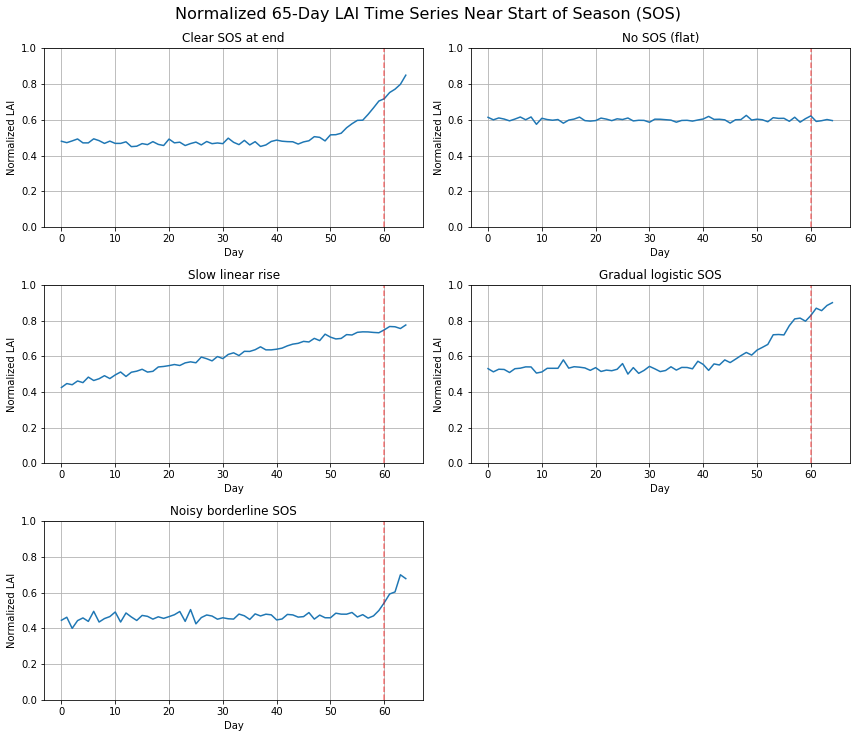

In [48]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
days_65 = np.linspace(0, 64, 65)
sos_test_cases = []

def normalize_lai(lai, target_max=0.65, target_amp=0.4):
    min_val = np.min(lai)
    max_val = np.max(lai)
    # Avoid division by zero
    if max_val - min_val == 0:
        return np.full_like(lai, target_max - target_amp / 2)
    scaled = (lai - min_val) / (max_val - min_val)
    return scaled * target_amp + (target_max - target_amp / 2)

# Case A: Clear SOS in last few days
lai1 = 2.0 / (1 + np.exp(-0.25 * (days_65 - 60))) + 0.05 * np.random.normal(0, 1, len(days_65))
sos_test_cases.append(normalize_lai(lai1))

# Case B: No SOS (flat/no-growth)
lai2 = 0.5 + 0.02 * np.random.normal(0, 1, len(days_65))
sos_test_cases.append(normalize_lai(lai2, target_max=0.6, target_amp=0.05))

# Case C: Slow linear increase (approaching SOS)
lai3 = 0.01 * days_65 + 0.02 * np.random.normal(0, 1, len(days_65))
sos_test_cases.append(normalize_lai(lai3, target_max=0.6, target_amp=0.35))

# Case D: Gradual logistic rise starting near day 55
lai4 = 1.5 / (1 + np.exp(-0.2 * (days_65 - 55))) + 0.05 * np.random.normal(0, 1, len(days_65))
sos_test_cases.append(normalize_lai(lai4, target_max=0.7))

# Case E: Noisy with weak rise late (borderline SOS)
lai5 = 0.1 * (days_65 > 58) * (days_65 - 58) + 0.05 * np.random.normal(0, 1, len(days_65))
sos_test_cases.append(normalize_lai(lai5, target_max=0.55, target_amp=0.3))

# Labels
sos_labels = [
    "Clear SOS at end",
    "No SOS (flat)",
    "Slow linear rise",
    "Gradual logistic SOS",
    "Noisy borderline SOS"
]

# Plot the normalized SOS-focused time series
plt.figure(figsize=(12, 10))
for i, (lai, label) in enumerate(zip(sos_test_cases, sos_labels)):
    plt.subplot(3, 2, i + 1)
    plt.plot(days_65, lai, label=label)
    plt.axvline(x=60, color='red', linestyle='--', alpha=0.5, label='Day 60')
    plt.title(label)
    plt.xlabel("Day")
    plt.ylabel("Normalized LAI")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
plt.suptitle("Normalized 65-Day LAI Time Series Near Start of Season (SOS)", fontsize=16, y=1.02)
plt.show()


# preprocessing 

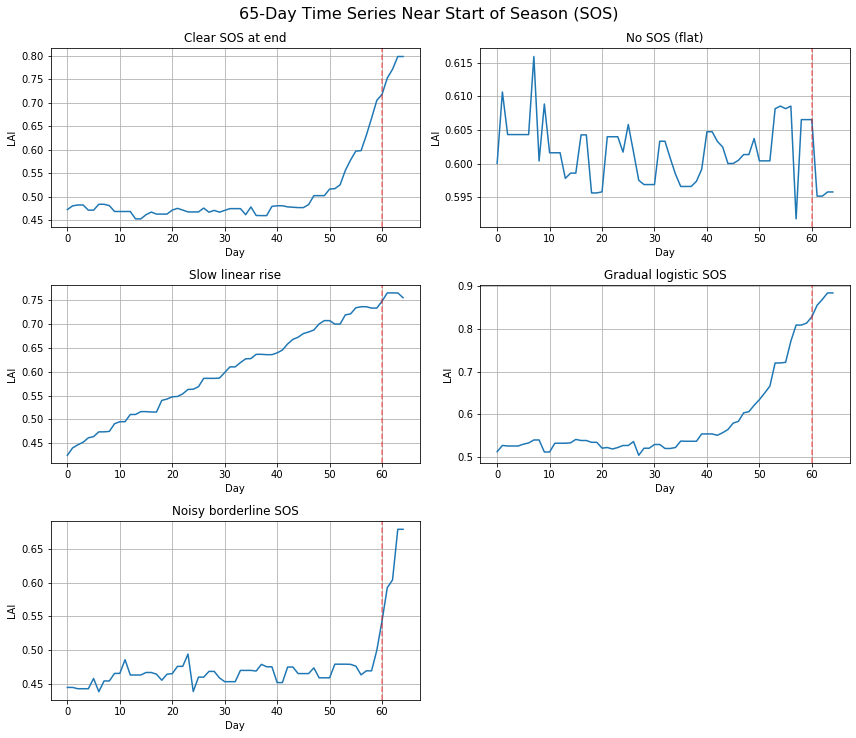

In [49]:
input_LAI= sos_test_cases[1]
# preprocessing using a 15 point median value filter to smooth input series
smoothed_LAI_cases = [medfilt(i, kernel_size=3) for i in sos_test_cases]
plot_tests(smoothed_LAI_cases)

In [50]:
# determine period with exhibited sustained increased for logistic curve fitting

def get_tp(lai_ts, annual_amp = 0.6, peak_LAI = 0.7 ):
    # Step 2: Compute slope (first difference)
    slope = np.diff(lai_ts)
    
    transition_idx = None
    for i in range(1, len(slope)):
        if slope[i - 1] > 0 and slope[i] <= 0:
            if max(lai_ts[:transition_idx])>= (0.7*peak_LAI) and max(lai_ts[:transition_idx])-min(lai_ts[:transition_idx])>=0.35*annual_amp:
                transition_idx = i
                break
    return transition_idx


print( [get_tp(i) for i in smoothed_LAI_cases])




[2, None, 6, 1, 5]


In [51]:
# Logistic function for VI curve fitting
def logistic(t, a, b, c, d):
    return c / (1 + np.exp(a + b * t)) + d

# Derivative of curvature change (rate of change of curvature KV)
def curvature(t, a, b, c, d):
    z = np.exp(a + b * t)
    denom = ((1+z)**4 + (b*c*z)**2)**(3/2)
    num = (b**2) * c * z * (1-z) * ((1+z)**3)
    return num / denom

def curvature_rate_of_change(t, a, b, c, d):
    z = np.exp(a + b * t)
    z1=1-z
    z2=1+z
    z3= (b*c*z)**2
    partone_num= 3*z*(1-z)*((1+z)**3)  *   (2* (1+z)**3 + ((b**2)*(c**2)*z))
    partone_denom=((1+z)**4 + (z3))**(5/2)

    parttwo_num= (1+z)**2 * (1+2*z-5*z**2)
    parttwo_denom= ((1+z)**4+z3)**(3/2)
    
    difference = (partone_num/partone_denom) - (parttwo_num/parttwo_denom)
    return b**3*c*z*difference

def normalize_timeseries_sklearn(series):
    series = np.asarray(series).reshape(-1, 1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(series).flatten()



0.34654151777916753
First local maximum at index 50, value: 0.00031534733074505754
50 0.00031534733074505754
0.024074662368615996
None None
0.3400461966895097
None None
0.38001660443046237
First local maximum at index 44, value: 0.00016940803596653
44 0.00016940803596653
0.23950779068456463
First local maximum at index 58, value: 0.005221942215774598
58 0.005221942215774598


/glade/u/ssg/ch/usr/jupyterhub/envs/notebook-gallery-2019.12/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
/glade/u/ssg/ch/usr/jupyterhub/envs/notebook-gallery-2019.12/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in power
/glade/u/ssg/ch/usr/jupyterhub/envs/notebook-gallery-2019.12/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in multiply
/glade/u/ssg/ch/usr/jupyterhub/envs/notebook-gallery-2019.12/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/glade/u/ssg/ch/usr/jupyterhub/envs/notebook-gallery-2019.12/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


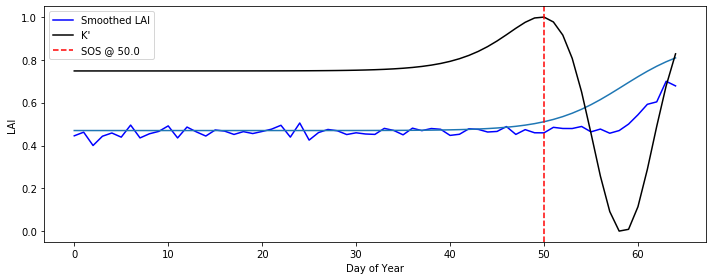

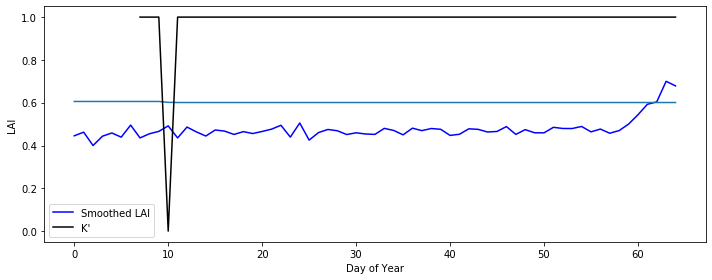

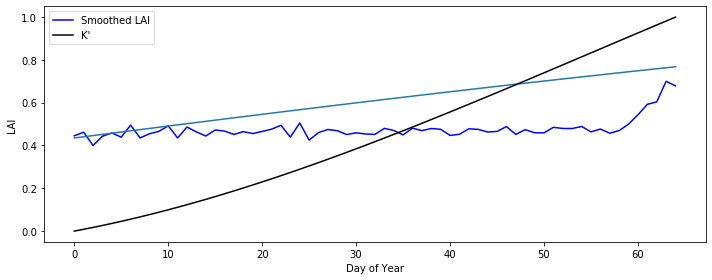

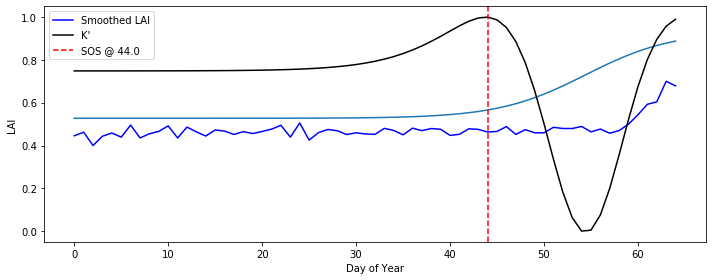

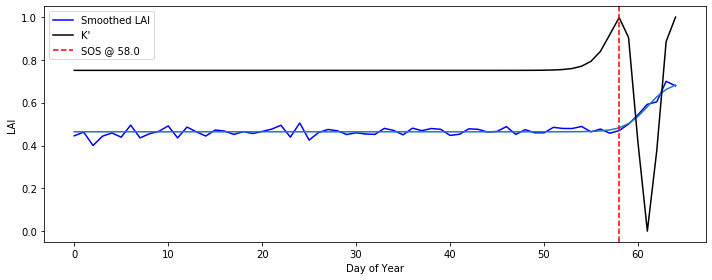

In [76]:
max_lai=1

K_ts = []
for LAI_segment in smoothed_LAI_cases: 
    days_year = np.linspace(0, len(LAI_segment)-1, len(LAI_segment))
        
    # Initial guess for parameters
    p0 = [-5, 0.1, max(LAI_segment)*2, min(LAI_segment)]
    popt, _ = curve_fit(logistic, days_year, LAI_segment, p0, maxfev=10000)
    kv = curvature_rate_of_change(days_year, *popt)
    K_ts.append(kv)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(days_year, lai, label="Smoothed LAI", color='blue', linewidth=1.5)
    ax.plot(days_year, logistic(days_year, *popt))
    print(max(LAI_segment)-min(LAI_segment))
    if max(LAI_segment)>0.3:
        ax.plot(days_year, normalize_timeseries_sklearn(kv), label="K'", color='black', linewidth=1.5)
    sos_doy, sos_lai = find_sos(days_year, kv)
    print(sos_doy, sos_lai)
    if sos_doy != None:
        ax.axvline(sos_doy, color='red', linestyle='--', label=f"SOS @ {sos_doy:.1f}")
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("LAI")
    ax.legend()
    plt.tight_layout()

    

In [43]:
len(K_ts[0])

65

In [62]:
# Plotting smoothed LAI and detected transitions
for i, lai in enumerate(smoothed_LAI_cases):
    fig, ax = plt.subplots(figsize=(10, 4))
    lai = smooth_timeseries(lai)
    ax.plot(days_year, lai, label="Smoothed LAI", color='blue', linewidth=1.5)
    transitions, popt,  kvs = transition_dates(days_year, lai)

    print(len(kvs[0]))
    ax.plot(days_year, logistic(days_year, *popt))
        ax.axvline(td, color='red', linestyle='--', label=f"Transition @ {td:.1f}")
    ax.plot(days_year[:len(kvs[0])], normalize_timeseries_sklearn(kvs[0]), label="K'", color='black', linewidth=1.5)
    ax.plot(days_year[len(kvs[0])+1:], normalize_timeseries_sklearn(kvs[1]), label="K'", color='black', linewidth=1.5)
    ax.set_title(f"Smoothed 365-Day Test Case {chr(65 + i)}")
    sos_doy, sos_lai = find_sos(days, lai)
    if sos_doy != None:
        ax.axvline(sos_doy, color='red', linestyle='--', label=f"SOS @ {sos_doy:.1f}")
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("LAI")
    ax.legend()
    plt.tight_layout()
    plt.show()


IndentationError: unexpected indent (<ipython-input-62-94134a7e6fcf>, line 10)

In [74]:
def find_sos(days, K):# Find all peaks
    peaks, _ = find_peaks(K)
    
    # Get the first peak index and value
    if len(peaks) >= 1:
        first_peak_idx = peaks[0]
        first_peak_value = K[first_peak_idx]
        print(f"First local maximum at index {first_peak_idx}, value: {first_peak_value}")
    else:
        return None, None
    return first_peak_idx, first_peak_value
